In [1]:
import joblib

import torch
import torch.nn as nn
import torch.optim as opt
import torch.autograd as auto
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.externals import joblib
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F



In [2]:
w2v_file='C:/Users/Subhani/Documents/Jupyter IR/Project/Advanced dataset/1/word_embeddings_dataset_1.sav'
dataset= joblib.load(w2v_file)
len(dataset)

11112

In [3]:
# max_len= -1
# min_len=1000000
# for i in dataset:
#     if(max_len<=len(i[0])):
#         max_len=len(i[0])
#     if(min_len>=len(i[0])):
#         min_len=len(i[0])
# print(max_len,min_len)

In [4]:
max_len=100

In [5]:
X,y=[],[]
for i in dataset:
    if(len(i[1])>max_len):
        continue
    temp=i[1]
    if(len(i[1])<max_len):
        for j in range(max_len-len(i[1])):
            pad=[0 for k in range(300)]
            temp.append(pad)
        X.append(temp)
    else:
        X.append(i[1])
    y.append(i[2])

In [6]:
print(len(X),len(y))

11108 11108


In [7]:
count=0
for i in X:
    if(max_len==len(i)):
#         print('---')
        count+=1
print(count)

11108


In [8]:
# dataset[1]
# dataset[0][2]

In [9]:
# X[1]
# y[0]

In [10]:
print(len(X),len(y))

11108 11108


In [11]:
print(len(X[0]))

100


In [12]:
# y_dictionary={'nonfactual':0,
#               'factual':1,}

# for i in range(0,len(y)):
#     y[i]=y_dictionary.get(y[i])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.Tensor(y_train)
y_test=torch.Tensor(y_test)

In [15]:
BATCH_SIZE = 16

In [16]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE * 2)

In [17]:
# parameters 

N_STEPS = 100
N_INPUTS = 300
N_NEURONS = 300
N_OUTPUTS = 2
N_EPHOCS = 10

In [18]:
class Factual_LSTM(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(Factual_LSTM, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        print(batch_size, n_steps, n_inputs, n_neurons, n_outputs)
#         self.lstm = nn.LSTM(self.n_inputs, self.n_neurons,3,dropout=0.2)
        self.lstm = nn.LSTM(self.n_inputs, self.n_neurons,3)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons),torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.lstm(X)  
        out = self.FC(lstm_out[-1])
        
        return out.view(-1, self.n_outputs)


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Factual_LSTM(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = F.cross_entropy
# optimizer = optim.Adam(model.parameters(), lr=5e-3)
optimizer = optim.SGD(model.parameters(), lr =5e-3, momentum=0.9)

def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

16 100 300 300 2


In [20]:
def eval_model(model, val_iter):
    total_epoch_loss = 0
    valid_acc = 0
    total_epoch_acc=0
    model.cuda()
    model.eval()
    num_corrects=0
    total=0
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            inputs = batch[0]
            
            target = batch[1]
            target = torch.autograd.Variable(target).long()
            
            inputs=inputs.cuda()
            target=target.cuda()
            prediction = model(inputs)
            loss = criterion(prediction, target)
        
            _, predicted = torch.max(prediction.data, 1)
            num_corrects += (predicted == target).sum().item()
            
            total+=target.size(0)
            total_epoch_loss += loss.item()
        acc = 100.0 * num_corrects/total
        
    return total_epoch_loss/len(val_iter), acc

In [21]:
for_plot_loss=[]
for_plot_acc=[]

val_loss=[]
val_acc=[]
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.cuda()
    model.train()
    num_corrects=0
    total=0
    
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        
        model.hidden = model.init_hidden() 
        
        inputs, labels = data
        inputs = inputs.view(-1, 100,300)
        
        inputs=inputs.cuda()
        labels=labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        num_corrects += (predicted == labels.long()).sum().item()
        total+=labels.size(0)
    
    acc = 100.0 * num_corrects/total
    for_plot_loss.append(train_running_loss/i)
    for_plot_acc.append(acc)
    
    model.eval()
    
    valid_loss,valid_accuracy=eval_model(model,test_dl)
    
    val_loss.append(valid_loss)
    val_acc.append(valid_accuracy)
    
#     print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
#           %(epoch, train_running_loss / i, acc),'==>',valid_loss,valid_accuracy)
    print('Epoch:  %d | Train_Loss: %.4f | Train_Accuracy: %.2f | Validation_Loss: %.4f | Validation_Accuracy: %.2f' 
          %(epoch, train_running_loss / i, acc,valid_loss,valid_accuracy))

Epoch:  0 | Train_Loss: 0.6893 | Train_Accuracy: 55.44 | Validation_Loss: 0.6906 | Validation_Accuracy: 53.78
Epoch:  1 | Train_Loss: 0.6889 | Train_Accuracy: 55.44 | Validation_Loss: 0.6903 | Validation_Accuracy: 53.78
Epoch:  2 | Train_Loss: 0.6892 | Train_Accuracy: 55.44 | Validation_Loss: 0.6904 | Validation_Accuracy: 53.78
Epoch:  3 | Train_Loss: 0.6891 | Train_Accuracy: 55.44 | Validation_Loss: 0.6915 | Validation_Accuracy: 53.78
Epoch:  4 | Train_Loss: 0.6893 | Train_Accuracy: 55.44 | Validation_Loss: 0.6903 | Validation_Accuracy: 53.78
Epoch:  5 | Train_Loss: 0.6889 | Train_Accuracy: 55.44 | Validation_Loss: 0.6902 | Validation_Accuracy: 53.78
Epoch:  6 | Train_Loss: 0.6888 | Train_Accuracy: 55.44 | Validation_Loss: 0.6914 | Validation_Accuracy: 53.78
Epoch:  7 | Train_Loss: 0.6891 | Train_Accuracy: 55.44 | Validation_Loss: 0.6902 | Validation_Accuracy: 53.78
Epoch:  8 | Train_Loss: 0.6892 | Train_Accuracy: 55.44 | Validation_Loss: 0.6902 | Validation_Accuracy: 53.78
Epoch:  9 

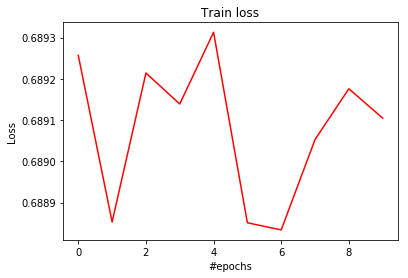

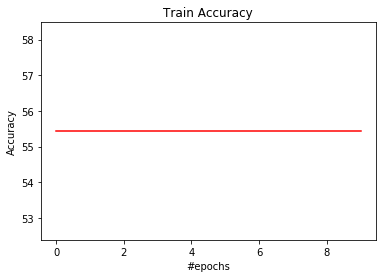

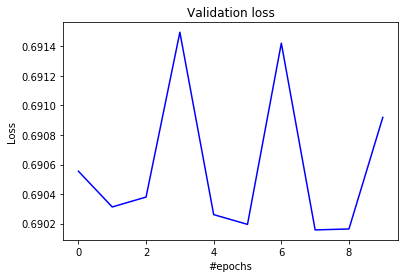

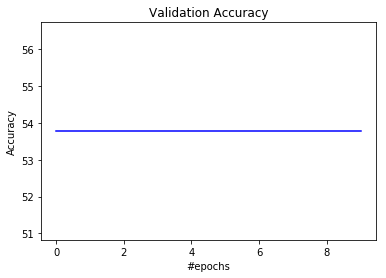

In [22]:
import matplotlib.pyplot as plt

plt.title('Train loss')
plt.plot(range(len(for_plot_loss)),for_plot_loss, color='r')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Train Accuracy')
plt.plot(range(len(for_plot_acc)),for_plot_acc,color='r')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.show()

plt.title('Validation loss')
plt.plot(range(len(val_loss)),val_loss,color='b')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.show()

plt.title('Validation Accuracy')
plt.plot(range(len(val_acc)),val_acc,color='b')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.show()

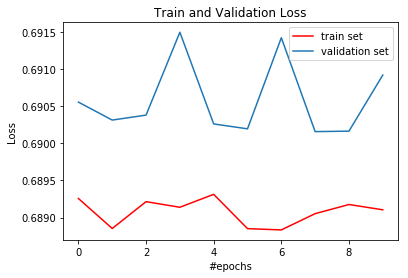

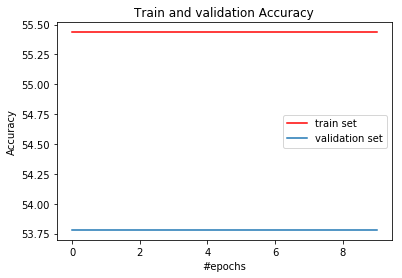

In [23]:
plt.title('Train and Validation Loss')
plt.plot(range(len(for_plot_loss)),for_plot_loss, color='r',label='train set')
plt.plot(range(len(val_loss)),val_loss,label='validation set')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Train and validation Accuracy')
plt.plot(range(len(for_plot_acc)),for_plot_acc,color='r',label='train set')
plt.plot(range(len(val_acc)),val_acc,label='validation set')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()